## Partie 1 : Exploration des Donnees

### 1.1 Chargement et apercu

- Identifiez les types de variables (numeriques, categorielles)
- Verifiez les valeurs manquantes
- Detectez les valeurs aberrantes

In [1]:
from sklearn.datasets import fetch_california_housing
import pandas as pd

housing = fetch_california_housing(as_frame=True)
df: pd.DataFrame = housing.frame

print(f"Nombre d'observations : {df.shape[0]}")
print(f"Nombre de features : {df.shape[1] - 1}")

Nombre d'observations : 20640
Nombre de features : 8


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


- Valeurs numériques uniquement
- Pas de valeur manquante

In [3]:
df.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


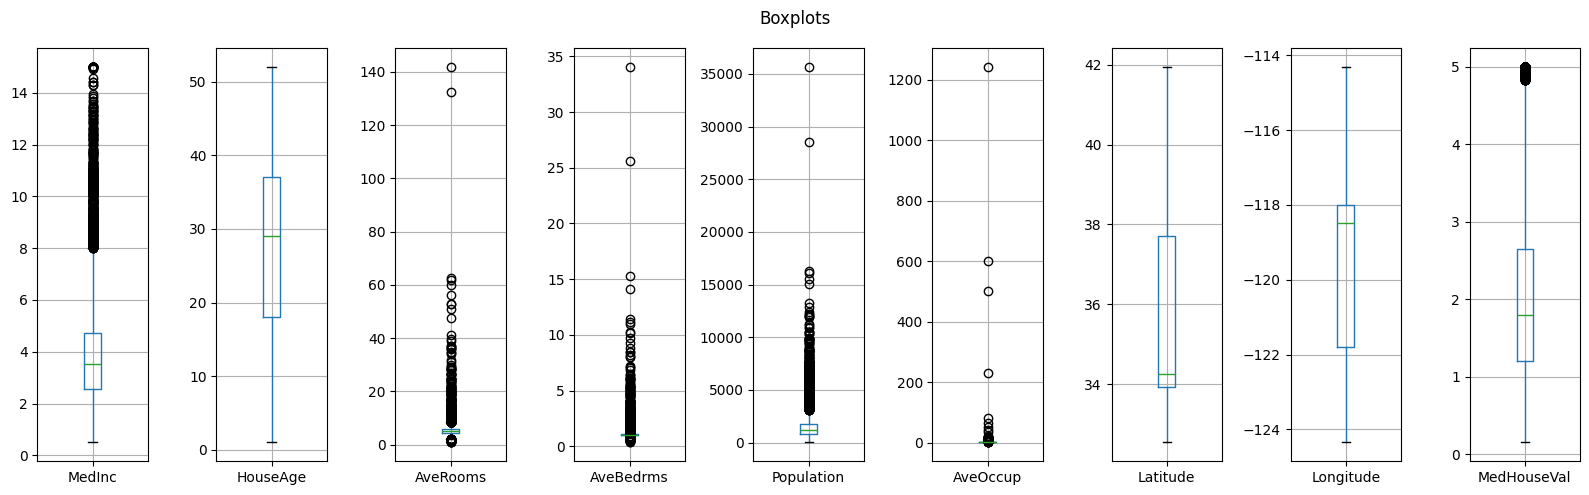

In [49]:
import matplotlib.pyplot as plt

nb_columns = len(df.columns.to_list())

fig, axes = plt.subplots(1, nb_columns, figsize=(16, 5))
fig.suptitle("Boxplots")

for k, col in enumerate(df.columns.to_list(), 0):
    df.boxplot(column=col, ax=axes[k])

plt.tight_layout()
plt.show()

Outlers potentiels :
- AveRooms > 80
- AveBedrms > 13
- Population > 20000
- AveOccup > 20

In [50]:
df_outliers1 = df.loc[
    (df["AveRooms"] < 80)
    & (df["AveBedrms"] < 13)
    & (df["Population"] < 20_000)
    & (df["AveOccup"] < 20)
]

print("Nombre de lignes dataset original : ", len(df))
print("Nombre de lignes dataset après suppression des outlers : ", len(df_outliers1))
print("Nombre de lignes supprimées : ", len(df) - len(df_outliers1))

Nombre de lignes dataset original :  20640
Nombre de lignes dataset après suppression des outlers :  20624
Nombre de lignes supprimées :  16


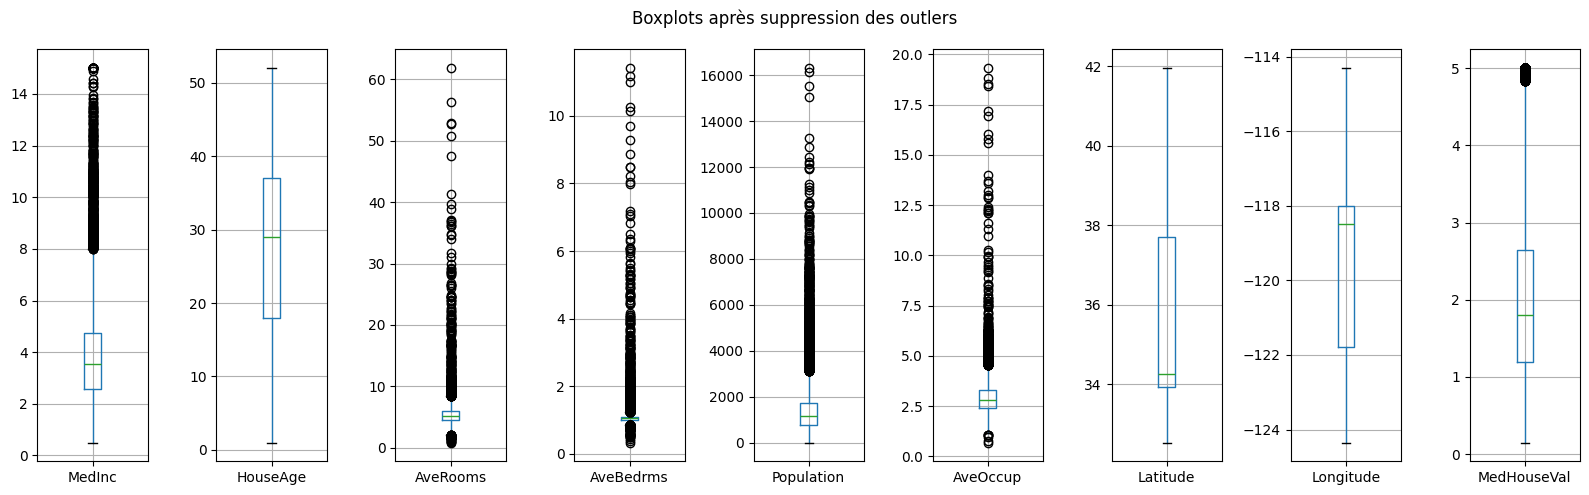

In [51]:
nb_columns = len(df_outliers1.columns.to_list())

fig, axes = plt.subplots(1, nb_columns, figsize=(16, 5))
fig.suptitle("Boxplots après suppression des outlers")

for k, col in enumerate(df_outliers1.columns.to_list(), 0):
    df_outliers1.boxplot(column=col, ax=axes[k])

plt.tight_layout()
plt.show()

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


def detect_outliers_multicolumn(
    data: pd.DataFrame,
    columns: list[str],
    sigma_threshold: float = 3.0,
    q1: float = 0.25,
    q3: float = 0.75,
    iqr_factor: float = 1.5,
    show_plot: bool = True,
) -> pd.DataFrame:
    """
    Détection des outliers sur plusieurs colonnes numériques
    avec les méthodes :
    - 3 sigma
    - Tukey (IQR)
    """

    df = data.copy()

    for col in columns:
        x = df[col]

        # 3 SIGMA
        mean = x.mean()
        std = x.std()

        lower_sigma = mean - sigma_threshold * std
        upper_sigma = mean + sigma_threshold * std

        df[f"is_outlier_sigma_{col}"] = (x < lower_sigma) | (x > upper_sigma)

        # TUKEY
        q1_val = x.quantile(q1)
        q3_val = x.quantile(q3)
        iqr = q3_val - q1_val

        lower_tukey = q1_val - iqr_factor * iqr
        upper_tukey = q3_val + iqr_factor * iqr

        df[f"is_outlier_tukey_{col}"] = (x < lower_tukey) | (x > upper_tukey)

        # VISUALISATION
        if show_plot:
            plt.figure(figsize=(8, 3))
            sns.boxplot(x=x, color="lightgray", width=0.4)

            sigma_outliers = x[df[f"is_outlier_sigma_{col}"]]
            tukey_outliers = x[df[f"is_outlier_tukey_{col}"]]

            plt.scatter(
                sigma_outliers,
                np.zeros(len(sigma_outliers)),
                color="red",
                label="Outliers 3 sigma",
                zorder=3,
            )

            plt.scatter(
                tukey_outliers,
                np.zeros(len(tukey_outliers)),
                color="blue",
                label="Outliers Tukey",
                zorder=3,
            )

            plt.title(f"Outliers - {col} (Tukey q1={q1}, q3={q3})")
            plt.xlabel(col)
            plt.yticks([])
            plt.legend()
            plt.show()

    return df

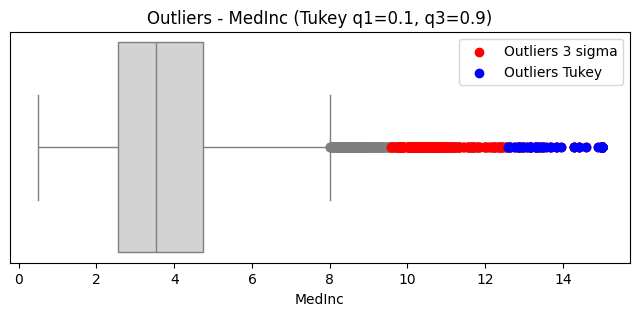

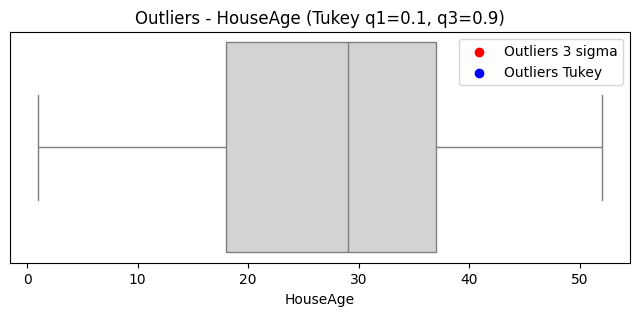

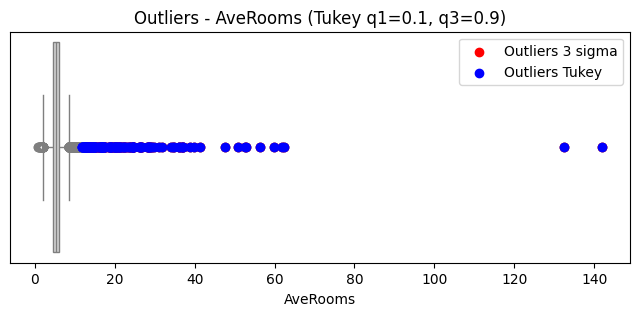

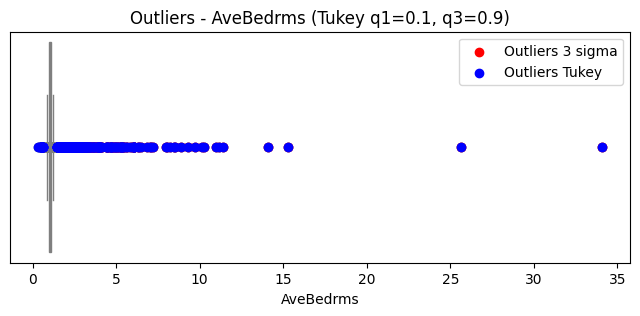

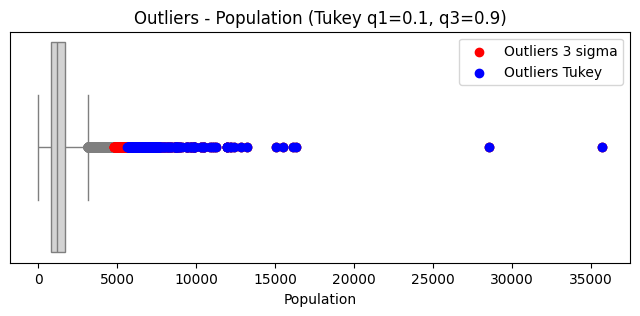

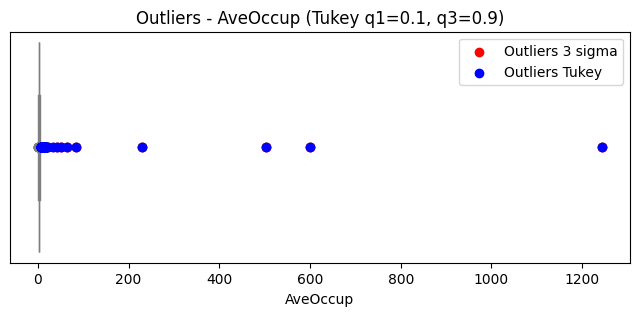

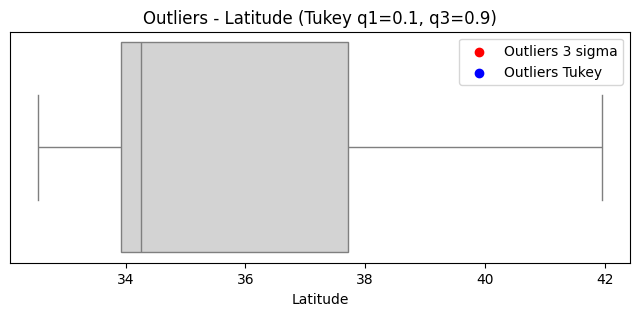

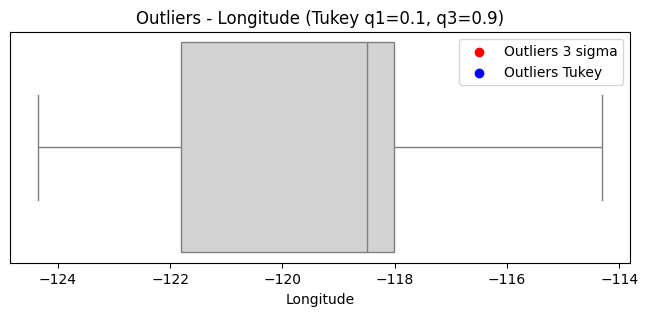

In [115]:
df_outliers2 = detect_outliers_multicolumn(
    data=df,
    columns=[
        "MedInc",
        "HouseAge",
        "AveRooms",
        "AveBedrms",
        "Population",
        "AveOccup",
        "Latitude",
        "Longitude",
    ],
    sigma_threshold=3,
    q1=0.1,
    q3=0.9,
    show_plot=True,
)

In [116]:
df_outliers2.filter(like="is_outlier_tukey").sum()

is_outlier_tukey_MedInc         92
is_outlier_tukey_HouseAge        0
is_outlier_tukey_AveRooms      149
is_outlier_tukey_AveBedrms     542
is_outlier_tukey_Population    222
is_outlier_tukey_AveOccup       77
is_outlier_tukey_Latitude        0
is_outlier_tukey_Longitude       0
dtype: int64

In [117]:
df_outliers2.filter(like="is_outlier_sigma").sum()

is_outlier_sigma_MedInc        345
is_outlier_sigma_HouseAge        0
is_outlier_sigma_AveRooms      133
is_outlier_sigma_AveBedrms     145
is_outlier_sigma_Population    342
is_outlier_sigma_AveOccup        8
is_outlier_sigma_Latitude        0
is_outlier_sigma_Longitude       0
dtype: int64

In [118]:
df_outliers2[df_outliers2.filter(like="is_outlier").any(axis=1)]

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal,is_outlier_sigma_MedInc,...,is_outlier_sigma_AveBedrms,is_outlier_tukey_AveBedrms,is_outlier_sigma_Population,is_outlier_tukey_Population,is_outlier_sigma_AveOccup,is_outlier_tukey_AveOccup,is_outlier_sigma_Latitude,is_outlier_tukey_Latitude,is_outlier_sigma_Longitude,is_outlier_tukey_Longitude
62,0.9011,50.0,6.229508,1.557377,377.0,3.090164,37.81,-122.29,0.861,False,...,False,True,False,False,False,False,False,False,False,False
63,1.1910,52.0,7.698113,1.490566,521.0,3.276730,37.81,-122.30,0.761,False,...,False,True,False,False,False,False,False,False,False,False
67,2.6094,52.0,6.986395,1.659864,492.0,3.346939,37.80,-122.29,0.813,False,...,False,True,False,False,False,False,False,False,False,False
73,0.4999,46.0,1.714286,0.571429,18.0,2.571429,37.81,-122.29,0.675,False,...,False,True,False,False,False,False,False,False,False,False
91,0.8668,52.0,2.443182,0.988636,904.0,10.272727,37.80,-122.28,1.375,False,...,False,False,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20530,3.1371,11.0,5.070223,1.015530,7984.0,2.695476,38.57,-121.76,2.018,False,...,False,False,True,True,False,False,False,False,False,False
20544,2.0650,23.0,4.803493,1.013646,6330.0,3.455240,38.55,-121.76,2.194,False,...,False,False,True,True,False,False,False,False,False,False
20563,3.1250,9.0,5.148007,1.119593,6837.0,2.899491,38.67,-121.75,1.325,False,...,False,False,True,True,False,False,False,False,False,False
20621,2.3661,37.0,7.923567,1.573248,484.0,3.082803,39.01,-121.47,0.775,False,...,False,True,False,False,False,False,False,False,False,False


### 1.2 Analyse de la variable cible

1. La distribution est-elle normale ?
2. Y a-t-il des valeurs plafonnees ou aberrantes ?

<Figure size 1200x500 with 0 Axes>

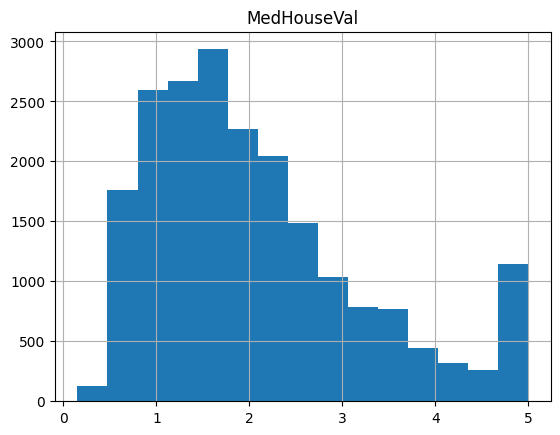

In [119]:
import numpy as np

plt.figure(figsize=(12, 5))
df_outliers2.hist(column="MedHouseVal", bins=1 + int(np.log2(len(df_outliers2))))
plt.show()

In [120]:
from scipy.stats import shapiro

df_sample = df_outliers2.sample(n=3_000)
statistic, p_value = shapiro(df_sample["MedHouseVal"])

print("Statistic W test Shapiro : ", statistic)
print("p-value test Shapiro : ", p_value)

Statistic W test Shapiro :  0.9093074752723267
p-value test Shapiro :  4.666695051130194e-39


Test de Shapiro :
- p_value << 0.01 donc le test est significatif
- statistic w = 0.91 donc la distribution est normale

In [121]:
print(
    "Nombre de valeurs atteignant la borne supérieure : ",
    len(
        df_outliers2.loc[
            df_outliers2["MedHouseVal"] == df_outliers2["MedHouseVal"].max()
        ]
    ),
)

Nombre de valeurs atteignant la borne supérieure :  965


De plus, on observe une forte proportion de valeur en queue de série donc les valeurs sont plafonnée.

In [122]:
print(
    "Nombre de valeurs négatives : ",
    len(df_outliers2.loc[df_outliers2["MedHouseVal"] < 0]),
)

Nombre de valeurs négatives :  0


In [123]:
df_max = df_outliers2.loc[
    df_outliers2["MedHouseVal"] < df_outliers2["MedHouseVal"].max()
]

print("Nombre de lignes dataset outlers : ", len(df_outliers2))
print("Nombre de lignes dataset après suppression des plafonds : ", len(df_max))
print("Nombre de lignes supprimées : ", len(df_outliers2) - len(df_max))

Nombre de lignes dataset outlers :  20640
Nombre de lignes dataset après suppression des plafonds :  19675
Nombre de lignes supprimées :  965


<Figure size 1200x500 with 0 Axes>

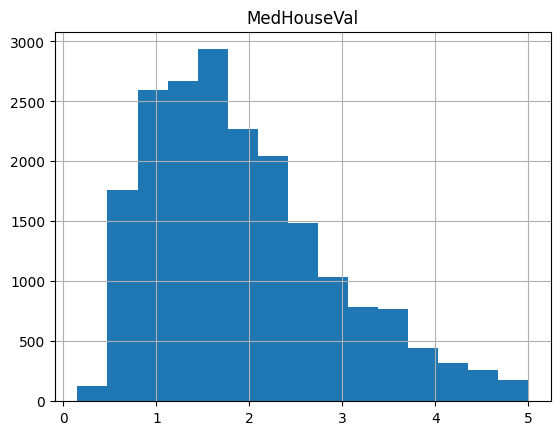

In [124]:
plt.figure(figsize=(12, 5))
df_max.hist(column="MedHouseVal", bins=1 + int(np.log2(len(df_outliers2))))
plt.show()

### 1.3 Analyse des correlations

1. Quelles features sont les plus correlees avec le prix ?

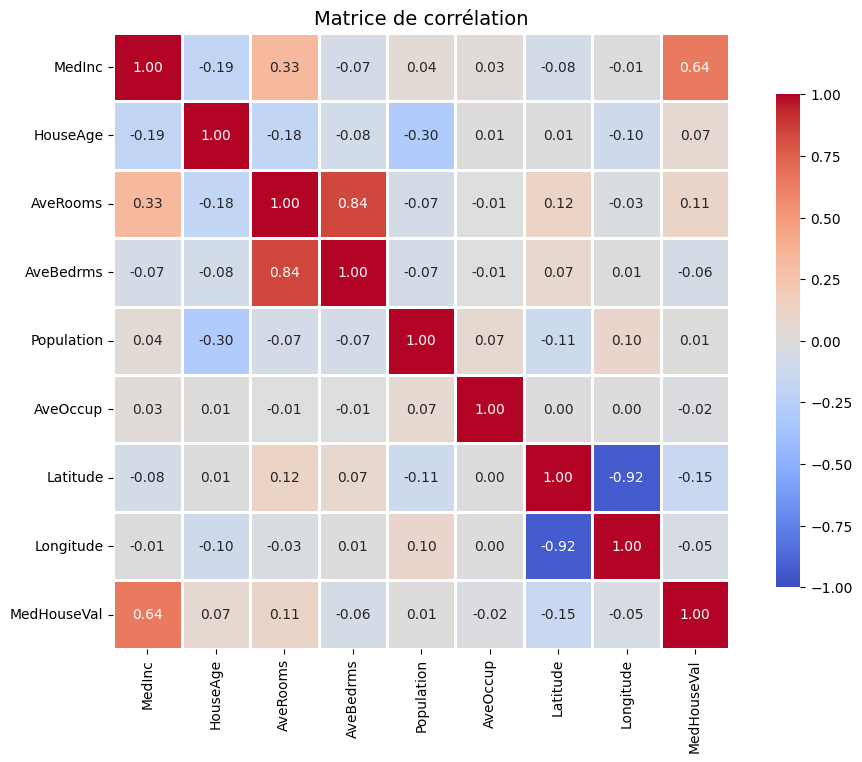

In [125]:
import seaborn as sns

df_corr = df_max.select_dtypes(include=["int", "float"]).copy()
mat_corr = df_corr.corr(method="pearson")

plt.figure(figsize=(12, 8))
plt.title("Matrice de corrélation", fontsize=14)

sns.heatmap(
    mat_corr,
    annot=True,
    cmap="coolwarm",
    center=0,
    vmin=-1,
    vmax=1,
    square=True,
    linewidths=1,
    cbar_kws={"shrink": 0.8},
    fmt=".2f",
)

plt.show()

- La feature la plus corrélée au prix est MedInc

### 1.4 Analyse spatiale (California Housing)

- Les zones cotieres sont-elles plus cheres ?

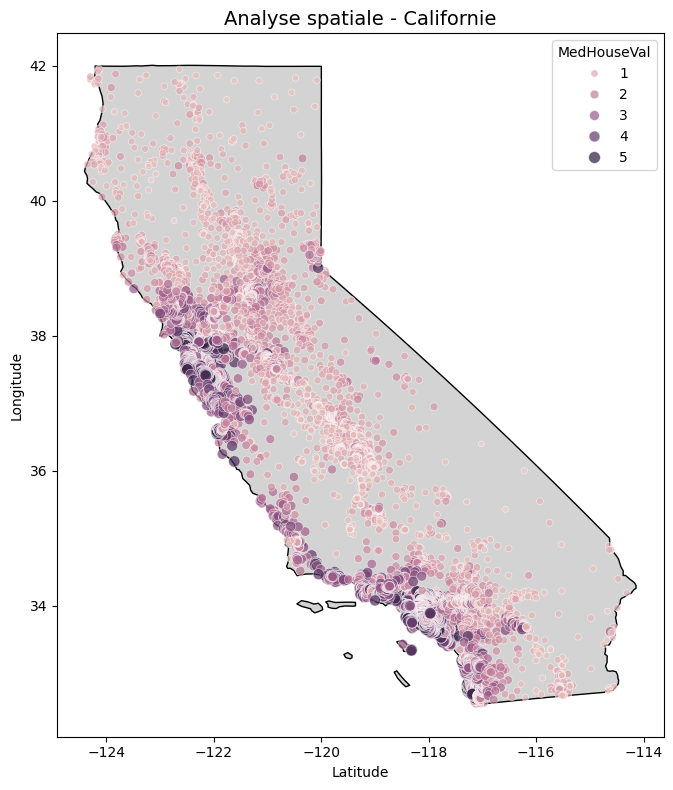

In [126]:
import geopandas as gpd

# Charger la carte des États US
usa = gpd.read_file(
    "https://www2.census.gov/geo/tiger/GENZ2021/shp/cb_2021_us_state_20m.zip"
)

# Filtrer la Californie
california = usa[usa["NAME"] == "California"]

# Figure
plt.figure(figsize=(12, 8))
ax = plt.gca()

# Tracer la carte de la Californie
california.plot(ax=ax, color="lightgrey", edgecolor="black")

# Scatter plot par-dessus
sns.scatterplot(
    data=df_max,
    y="Latitude",
    x="Longitude",
    size="MedHouseVal",
    hue="MedHouseVal",
    alpha=0.7,
    ax=ax,
)

plt.title("Analyse spatiale - Californie", fontsize=14)
plt.xlabel("Latitude")
plt.ylabel("Longitude")

plt.tight_layout()
plt.show()

- Les zones cotières sont plus chères

## Partie 2 : Preprocessing avec Pipeline

### 2.1 Strategie de preprocessing

Definissez une strategie pour chaque type de variable 

- Toutes les variables sont numériques, ayant supprimé les outlers et les valeurs plafonds, j'appliquerai un standard scaler

### 2.3 Feature Engineering (Bonus)

Creez des features supplementaires qui pourraient ameliorer le modele :

1. Implementez au moins 3 nouvelles features
2. Justifiez leur pertinence pour la prediction de prix

In [127]:
df_features = df_max.copy()
df_features["Rooms_per_Household"] = df_features["AveRooms"] / df_features["AveOccup"]
df_features["Bedrooms_ratio"] = df_features["AveBedrms"] / df_features["AveRooms"]
df_features["Inc_Age_Interaction"] = df_features["MedInc"] * df_features["HouseAge"]

In [128]:
df_features["Rooms_per_Household"] = (
    df_features["Rooms_per_Household"].replace([np.inf, -np.inf], 0).fillna(0)
)
df_features["Bedrooms_ratio"] = (
    df_features["Bedrooms_ratio"].replace([np.inf, -np.inf], 0).fillna(0)
)

### 2.2 Creation des transformers

In [129]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

features_to_keep = [
    "MedInc",
    "HouseAge",
    "AveRooms",
    "AveBedrms",
    "Population",
    "AveOccup",
    "Latitude",
    "Longitude",
    "Rooms_per_Household",
    "Bedrooms_ratio",
    "Inc_Age_Interaction",
]
target = "MedHouseVal"

X = df_features[features_to_keep].copy()
y = df_features[target].copy()

numeric_features = X.select_dtypes(include=["int", "float"]).columns.to_list()

# Pipeline pour les variables numériques
numeric_transformer = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
    ]
)

# Appliquer les pipelines
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
    ]
)

### 2.3 Évaluation du modèle

- R-squared (coefficient de determination)
- RMSE (Root Mean Squared Error)
- MAE (Mean Absolute Error)

In [130]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (
    mean_absolute_error,
    r2_score,
    mean_squared_error,
    root_mean_squared_error,
)

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
)

ml_pipeline = Pipeline(
    steps=[
        ("preprocessing", preprocessor),
        (
            "linear_regression",
            LinearRegression(),
        ),
    ]
)

# Entrainement du modèle sur les données d'entraînement
ml_pipeline.fit(X_train, y_train)

# Prédictions sur les données de test
y_pred = ml_pipeline.predict(X_test)

# Calcul du taux de bonnes prédictions
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"{mae = }")
print(f"{mse = }")
print(f"{rmse = }")
print(f"{r2 = }")

mae = 0.4472944672591385
mse = 0.3660005889563618
rmse = 0.6049798252473894
r2 = 0.6329344001362749
